In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from joblib import load
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = '../../data/original_data/dataset.csv'
df = pd.read_csv(dataset_path)

# Removing Empty Column
df.drop(columns=['id','Unnamed: 32'],inplace=True)

# Move diagnosis to be last column
df['diagnosis'] = df.pop('diagnosis')

# Display the first few rows of the dataset
df.head()

# Prepare X_train, X_test, y_train, y_test
X = df.drop(columns='diagnosis')
y = df['diagnosis']

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# Load the Logistic model from the fitted model file
best_model = load('../model_training/train_logistic_reg_best_model_2024-02-29.joblib')

# Fit the model to the entire dataset (or the training set)
# Replace X, y with the features and target variable
best_model.fit(X_train, y_train)

# Evaluate score
best_model.score(X_test,y_test)

/home/fox/Desktop/Model Engineering/iu-breast-cancer-identification/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9824561403508771

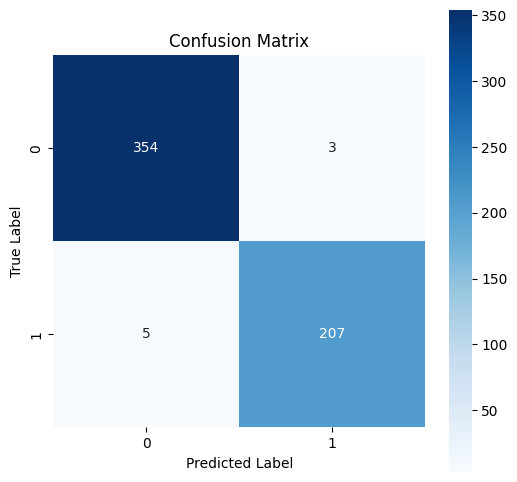

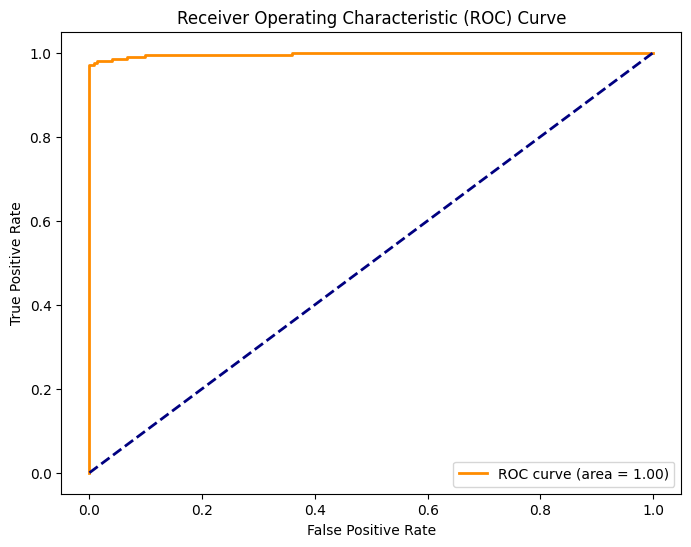

Classification Report:
               precision    recall  f1-score   support

           B       0.99      0.99      0.99       357
           M       0.99      0.98      0.98       212

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.99      0.99      0.99       569



In [3]:
# Make predictions on the test set
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]  # Get probabilities for the positive class

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('../../docs/evaluate_best_model_logistic_confusion_matrix.jpg')
plt.show()

# ROC Curve
# Specify 'M' as the positive class
fpr, tpr, thresholds = roc_curve(y, y_pred_proba, pos_label='M')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../../docs/evaluate_best_model_logistic_roc_curve.jpg')
plt.show()

# Classification Report
class_report = classification_report(y, y_pred)
print('Classification Report:\n', class_report)

In [4]:
# Access the logistic regression model from the pipeline
logreg_model = best_model.named_steps['logreg']
scaler = best_model.named_steps['scaler']

# Compute the standard errors of the coefficients (excluding intercept)
X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Add intercept to X_train
cov_matrix = np.linalg.inv(X_design.T.dot(X_design)) / len(X_train)
std_errors_features = np.sqrt(np.diag(cov_matrix))[1:]  # Exclude the first element for the intercept

# Compute confidence intervals for the standardized coefficients
ci_lower_std = logreg_model.coef_[0] - 1.96 * std_errors_features
ci_upper_std = logreg_model.coef_[0] + 1.96 * std_errors_features

# Adjust feature coefficients and their confidence intervals for the original scale
coefficients_original_scale = logreg_model.coef_[0] / scaler.scale_
ci_lower_original = ci_lower_std / scaler.scale_
ci_upper_original = ci_upper_std / scaler.scale_

# Adjust the intercept based on the means and standard deviations of the features
intercept_adjusted = logreg_model.intercept_ - np.sum((logreg_model.coef_[0] * scaler.mean_) / scaler.scale_)

# Create a DataFrame for standardized coefficients and their confidence intervals
coeff_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train.columns),
    'Standardized Coefficient': np.hstack([logreg_model.intercept_[0], logreg_model.coef_[0]]),
    'CI Lower (Standardized)': np.hstack([intercept_adjusted - 1.96 * std_errors_features[0], ci_lower_std]),
    'CI Upper (Standardized)': np.hstack([intercept_adjusted + 1.96 * std_errors_features[0], ci_upper_std]),
    'Original Scale Coefficient': np.hstack([intercept_adjusted, coefficients_original_scale]),
    'CI Lower (Original Scale)': np.hstack([intercept_adjusted - 1.96 * std_errors_features[0] / scaler.scale_[0], ci_lower_original]),
    'CI Upper (Original Scale)': np.hstack([intercept_adjusted + 1.96 * std_errors_features[0] / scaler.scale_[0], ci_upper_original])
})

# Display the DataFrame with most important features first (descending)
coeff_df = coeff_df.reindex(coeff_df['Standardized Coefficient'].abs().sort_values(ascending=False).index)
coeff_df.to_csv('evaluate_best_model_feature_importance_standardized_vs_regular_ci.csv')
coeff_df

,Feature,Standardized Coefficient,CI Lower (Standardized),CI Upper (Standardized),Original Scale Coefficient,CI Lower (Original Scale),CI Upper (Original Scale)
22,texture_worst,1.239513,1.236429,1.242597,0.204593,0.204084,0.205102
11,radius_se,1.170673,1.036388,1.304959,4.138855,3.664097,4.613614
29,symmetry_worst,1.142480,0.931300,1.353661,18.111094,14.763371,21.458816
8,concave points_mean,0.970180,0.067626,1.872734,25.518727,1.778769,49.258685
27,concavity_worst,0.889854,0.775557,1.004152,4.254260,3.707819,4.800700
21,radius_worst,0.855580,0.830233,0.880927,0.178024,0.172750,0.183298
14,area_se,0.840423,0.839839,0.841007,0.017811,0.017799,0.017824
24,area_worst,0.820558,0.820415,0.820701,0.001447,0.001447,0.001447
28,concave points_worst,0.799054,0.389065,1.209043,12.245239,5.962297,18.528180
7,concavity_mean,0.754304,0.299499,1.209109,9.502385,3.772959,15.231812


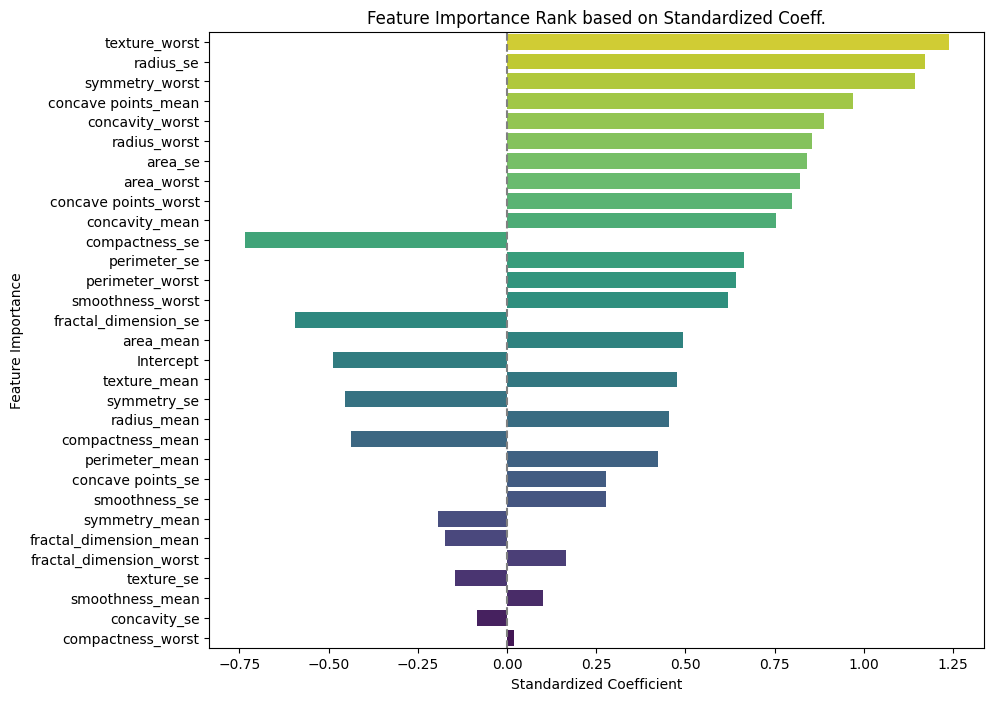

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(data=coeff_df, x='Standardized Coefficient', y='Feature', orient='h', palette='viridis_r', dodge=False, legend=False, hue='Feature')

# Add a line for zero to show positive and negative coefficients
plt.axvline(x=0, color='grey', linestyle='--')

# Add titles and labels
plt.title('Feature Importance Rank based on Standardized Coeff.')
plt.xlabel('Standardized Coefficient')
plt.ylabel('Feature Importance')

# Show the plot
plt.savefig('../../docs/evaluate_best_model_logistic_feature_importance_rank.jpg')
plt.show()

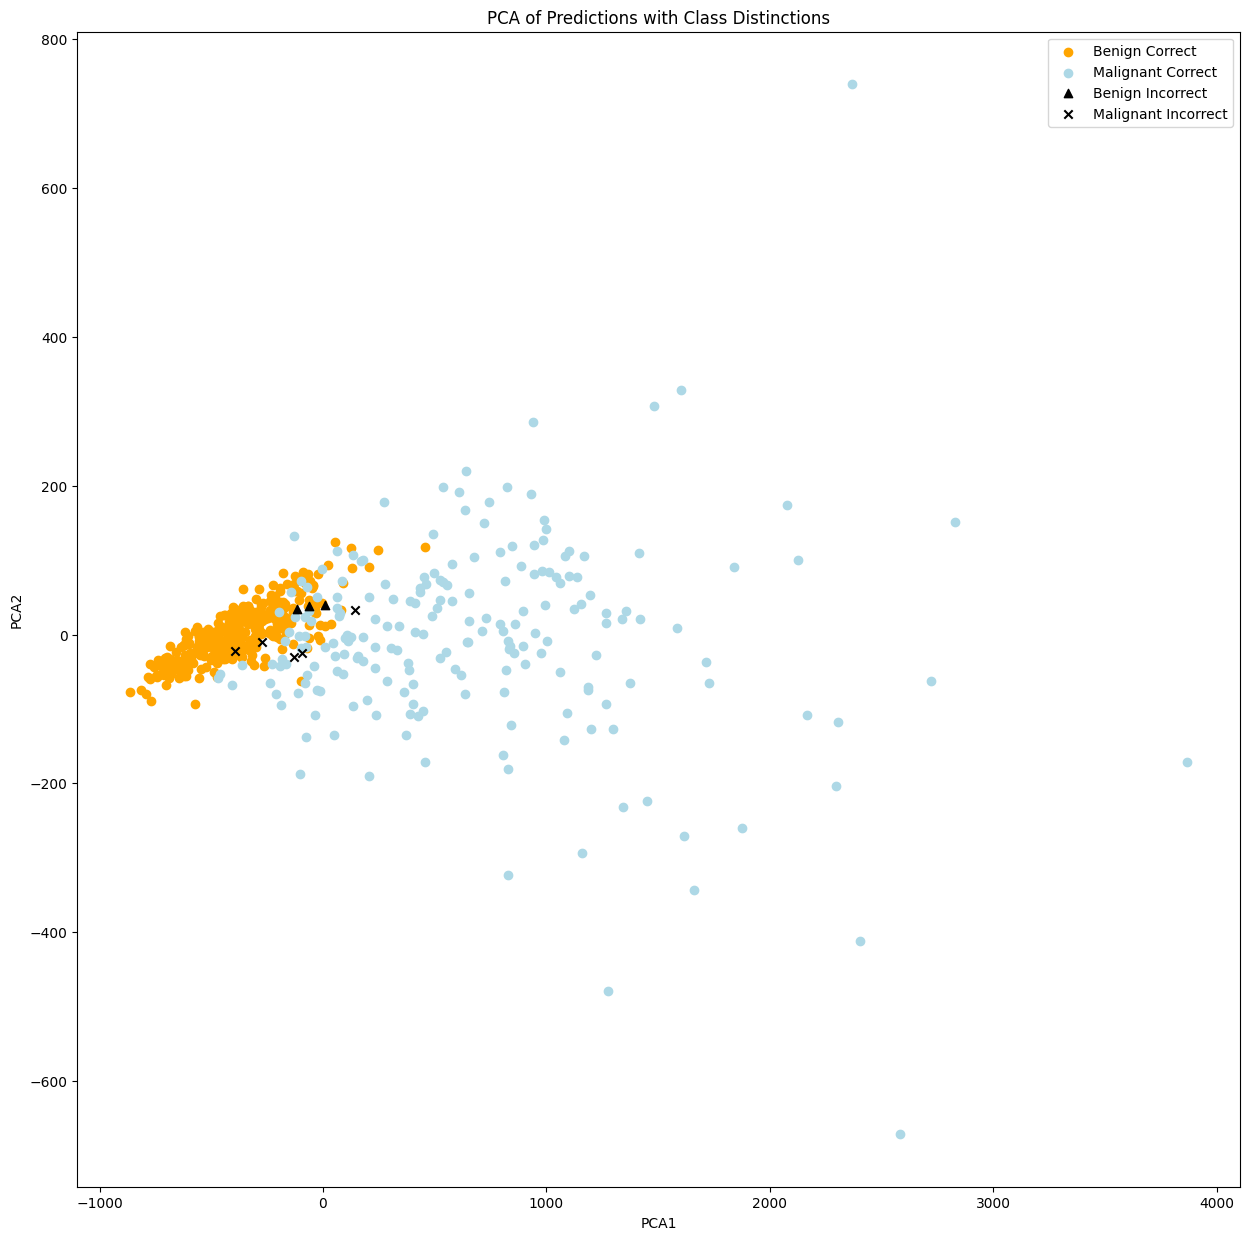

In [6]:
from sklearn.decomposition import PCA

# Assuming 'B' and 'M' are represented as 0 and 1 in the target variable 'y'
# Step 1: Apply PCA to reduce the features to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Make predictions using the trained model
predictions = best_model.predict(X)

# Adjust the conditions to match string representations
benign_indices = (y == 'B')
malignant_indices = (y == 'M')

# Ensure that correct and incorrect predictions are computed based on the actual values
correct_predictions = (predictions == y.values)
incorrect_predictions = ~correct_predictions

# Now, let's adjust the plotting code accordingly
plt.figure(figsize=(15, 15))

# Benign correct (black circle)
plt.scatter(X_pca[benign_indices & correct_predictions, 0], X_pca[benign_indices & correct_predictions, 1], c='orange', marker='o', label='Benign Correct')

# Malignant correct (black triangle)
plt.scatter(X_pca[malignant_indices & correct_predictions, 0], X_pca[malignant_indices & correct_predictions, 1], c='lightblue', marker='o', label='Malignant Correct')

# Benign incorrect (red circle)
plt.scatter(X_pca[benign_indices & incorrect_predictions, 0], X_pca[benign_indices & incorrect_predictions, 1], c='black', marker='^', label='Benign Incorrect')

# Malignant incorrect (red triangle)
plt.scatter(X_pca[malignant_indices & incorrect_predictions, 0], X_pca[malignant_indices & incorrect_predictions, 1], c='black', marker='x', label='Malignant Incorrect')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Predictions with Class Distinctions')
plt.legend()
plt.savefig('../../docs/evaluate_best_model_logistic_PCA_predictions_correct_incorrect.jpg')
plt.show()